In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("Identification").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

[Database(name='2022_10_22', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='2023_04_01', catalog='spark_catalog', description='FactSet data version for the day', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse'),
 Database(name='default', catalog='spark_catalog', description='Default Hive database', locationUri='hdfs://bialobog.cs.ucl.ac.uk:8020/user/hive/warehouse')]

In [2]:
from pyspark.sql.functions import regexp_replace

spark.sql("USE 2023_04_01")
    # Assuming that 'ticker' is a valid Python variable





DataFrame[]

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from datetime import datetime
from sklearn.linear_model import LinearRegression
from scipy.stats import norm
from pyspark.sql import Row
from pyspark.sql.functions import col, to_date, lit
from datetime import timedelta
from pyspark.sql.types import StructType, StructField, StringType, DateType
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
import csv

imploded_stocks = pd.read_csv('filtered_tickers.csv')
imploded_stocks = imploded_stocks['Ticker'].tolist()

sp500_stocks = pd.read_csv('constituents.csv', usecols=['Symbol'])
sp500_stocks = sp500_stocks['Symbol'].tolist()

start_date = '2009-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

def get_stock_price_weekly(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if temp_df.empty:
        #print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    return weekly_data

def get_stock_prices(ticker):
    # Suppress the progress message from yfinance
    query = f"""SELECT s.ticker_region, p.p_date, p.p_price FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                LEFT JOIN fp_basic_prices p ON p.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")
                ORDER BY p.p_date"""
    df = spark.sql(query)
    df.show(10)

def plot_price(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if temp_df.empty:
        #print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last()
    plt.figure(figsize=(15, 5))
    plt.plot(weekly_data.index, weekly_data, label=ticker)
    plt.legend()
    plt.show()
    
def plot_cum_returns(ticker):
    # Suppress the progress message from yfinance
    temp_df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    if temp_df.empty:
        #print("No data available for the specified date range.")
        return None
    weekly_data = temp_df['Adj Close'].resample('W').last().to_frame()
    print(weekly_data.head())
    weekly_data['returns']  = weekly_data['Adj Close'].pct_change()
    weekly_data['cumulative_returns'] = (1 + weekly_data['returns']).cumprod() - 1
    plt.figure(figsize=(15, 5))
    plt.plot(weekly_data.index, weekly_data['cumulative_returns'], label=ticker)
    #plt.plot(weekly_data.index, weekly_data['Adj Close'], color='yellow')
    plt.legend()
    plt.show()

def check_implosion(idx, firm_price, imp_thresh):
    i = idx
    start_price=firm_price.iloc[idx]
    i+=1
    period=0
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        if (current_price-start_price)/start_price > -imp_thresh/2:
            return period
        period+=1
        i+=1
    return period

def get_crash_dates(firm_price, price_drop_thresh=-0.6, period_thresh=52):
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_dates.append(current_date)
        i+=1
    return imp_dates

def get_implosion_dates(firm_price, price_drop_thresh=-0.6, period_thresh=52):
    crash_dates = []
    imp_dates = []
    i = 52
    while i < len(firm_price):
        current_date = firm_price.index[i]
        current_price = firm_price.iloc[i]
        prev_year_data = firm_price.iloc[i-52:i]
        if len(prev_year_data) != 0:
            mean_price = prev_year_data.mean()
            if (current_price - mean_price)/mean_price < price_drop_thresh:
                imp_period = check_implosion(i, firm_price,  price_drop_thresh)
                if imp_period > period_thresh:
                    imp_dates.append((current_date, firm_price.index[i+imp_period]))
                i+=imp_period
        i+=1
    return imp_dates

def plot_implosions(stock_series, imp_dates, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for i in imp_dates:
        plt.axvspan(i[0], i[1], alpha=0.5, color='blue')
    plt.legend()
    plt.show()

def run_imps(stocks_list):
    num_imp = 0
    j = 0
    for t in stocks_list:
        stock_series = get_stock_price_weekly(t)
        if stock_series is not None:
            imp_dates = get_implosion_dates(stock_series)
            if j % 10 == 0:
                plot_implosions(stock_series, imp_dates, t)    
            j+=1
            if len(imp_dates) >= 1:
                num_imp+=1
            # if len(imp_dates) ==0:
            #     plot_implosions(stock_series, imp_dates, t)
    print(f"{num_imp} out of {j} imploded")
    return num_imp

def plot_crashes(ticker):
    stock_series = get_stock_price_weekly(ticker)
    crash_dates = get_crash_dates(stock_series)
    plt.figure(figsize=(15, 5))
    plt.plot(stock_series.index, stock_series, label=ticker)
    for c in crash_dates:
        plt.axvspan(c,c, alpha=0.5, color='blue')
    plt.legend()
    plt.show()

def get_all_stocks():
    query = f"""SELECT s.ticker_region, sc.fref_listing_exchange FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")"""
    df = spark.sql(query)
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    ticker_list = [row.ticker_region for row in df.collect()]
    return ticker_list

def create_imploded_df(ticker_list):
    schema = StructType([StructField("Ticker", StringType(), True),
                     StructField("Implosion_Date", StringType(), True)])
    df = pd.read_csv('imploded_tickers_dates_test.csv', index_col=None, usecols=['Ticker','Implosion_Date'])
    #df = spark.createDataFrame([], schema)
    i = 0
    for t in ticker_list:
        stock_series = get_stock_price_weekly(t)
        if stock_series is not None and max(stock_series) > 5:
            imp_dates = get_implosion_dates(stock_series)
            if len(imp_dates)!=0:
                for date in imp_dates:
                    date_str = pd.to_datetime(date[0]).strftime('%Y-%m-%d')
                    # row = Row(Ticker=t, Implosion_Date=date_str)
                    # df = df.union(spark.createDataFrame([row],schema=schema))
                    new_row = pd.DataFrame({'Ticker': [t], 'Implosion_Date': [date_str]})
                    df = pd.concat([df, new_row], ignore_index=True)
            # if len(imp_dates)!= 0: 
            #     for d in imp_dates:
            #         date = d[0]
            #         df = df.withColumn('Imploded',when((col('Ticker') == t) & (year('Date') == date.year) & (month('Date') == date.month),1
            #             ).otherwise(col('Imploded'))) 
        if i>0 and i % 100 == 0:
            print(i)
            #df=df.orderBy('Ticker')
            df=df.sort_values(by='Ticker')
            df.to_csv('imploded_tickers_dates_test.csv', index='False')
        i+=1
    print(df.head(10)) 
    df=df.sort_values(by='Ticker')
    # df=df.orderBy('Ticker')
    df.to_csv('imploded_tickers_dates_test.csv', index='False')
    

# ticker_list = sorted(get_all_stocks()[:5000])

# create_imploded_df(ticker_list)
# df = pd.read_csv('imploded_tickers_dates')
# run_imps(df['Ticker'].unique().tolist())
#run_imps(['EMCMF'])
#add_labels_to_df('imploded_only.csv')
#plot_crashes('SEAC')
#APPN,CPS, FOSL, GRPN,PRLB, SEAC
#APPN has not imploded
#CPS has not imploded
#imploded: 377/433, sp500:  russell: 243/1754 imploded

# ticker_list = get_all_stocks()
# print(ticker_list)
# file_name = "all_stocks.csv"

# with open(file_name, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(ticker_list)

# with open('all_stocks.csv', mode='r') as file:
#     reader = csv.reader(file)
    
#     # Assuming there is only one row in the CSV file
#     ticker_list = next(reader, None)
    
# # Display the data list
# create_imploded_df(ticker_list)

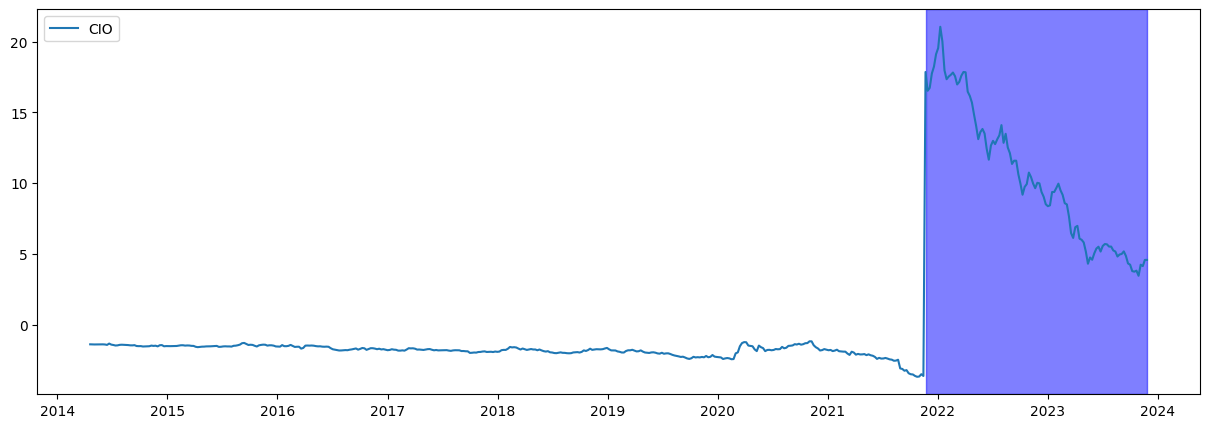

1 out of 1 imploded


1

In [9]:
df = pd.read_csv('imploded_tickers_dates_test.csv')
run_imps(['CIO'])

In [ ]:
def visualize_implosions(df):
    df['Implosion_Date'] = pd.to_datetime(df['Implosion_Date'])
    df = df[df['Implosion_Date'].dt.year==2020]
    df['month'] = df['Implosion_Date'].dt.month

    implosions_per_year = df.groupby('month').size()

    implosions_per_year.plot(kind='bar', color='skyblue')

    plt.title('Number of Implosions per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Implosions')

    plt.show()
    
df = pd.read_csv('imploded_tickers_dates.csv')
visualize_implosions(df)

In [ ]:
# import csv

# def save_weekly_prices():
#     filtered_tickers = []  # A list to store the ticker names

#     for ticker in russell_stocks:
#         t_df = get_stock_price_weekly(ticker)
#         if t_df is not None:
#             max_price = max(t_df)  # Replace 'price' with the actual column name
#             if max_price >= 100:
#                 filtered_tickers.append(ticker)

#     csv_file_name = 'filtered_russell_tickers.csv'

#     # Open the CSV file in write mode
#     with open(csv_file_name, mode='w', newline='') as file:
#         writer = csv.writer(file)  # Create a CSV writer object

#         # Write the ticker names to the CSV file
#         writer.writerow(['Ticker'])  # Write a header row
#         for ticker in filtered_tickers:
#             writer.writerow([ticker])

# save_weekly_prices()


In [ ]:
spark.stop()

In [ ]:
imploded_stocks

In [ ]:
def remove_low_tickers():
    df = pd.read_csv('imploded_tickers_dates.csv')
    tickers_to_remove = []
    print(len(df))

    for t in df['Ticker'].unique().tolist():
        stock_price = get_stock_price_weekly(t)
        if max(stock_price) < 5:
            tickers_to_remove.append(t)

    df = df[~df['Ticker'].isin(tickers_to_remove)]
    print(len(df))

    df.to_csv('imploded_tickers_dates.csv', index=False)
    
#remove_low_tickers()
            